In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

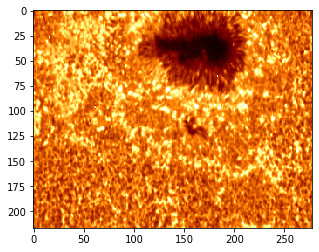

In [2]:
# opens in BGR colorspace, convert to RGB
img = cv2.cvtColor(cv2.imread("working_image.png"), cv2.COLOR_BGR2RGB)
plt.imshow(img)

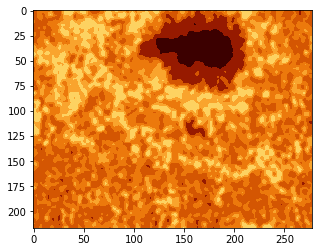

In [3]:
img_orig = img.copy()

# blur image to help smooth out edges
img = cv2.GaussianBlur(img, (7, 7), 0)

# convert to the shape of a vector of pixel values
Z = img.reshape((-1,3))
Z = np.float32(Z)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 6
ret, label, center = cv2.kmeans(Z, K, None, criteria, 50, cv2.KMEANS_RANDOM_CENTERS)
label = label.flatten()

# Convert back to uint8 and size of original image
center = np.uint8(center)
segmented = center[label.flatten()]
segmented = segmented.reshape((img.shape))

plt.imshow(segmented)

In [4]:
def find_threshold(img, label_name):
    masked_image = np.copy(img)

    # convert to shape of label array
    masked_image = masked_image.reshape((-1, 3))

    # make all pixels without that are not specified label white
    masked_image[~(label == label_name)] = [255, 255, 255]

    # convert back to original shape
    masked_image = masked_image.reshape(img.shape)
    
    # erode then dilate the image to remove noise
    kernel = np.ones((7,7),np.uint8)
    masked_image = cv2.morphologyEx(masked_image, cv2.MORPH_OPEN, kernel, iterations=1)
    gray = cv2.cvtColor(masked_image,cv2.COLOR_BGR2GRAY)

    # threshold image by removing all white pixels (not in label) 
    ret, thresh = cv2.threshold(gray, 254, 255, cv2.THRESH_BINARY_INV)
    
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    # create mask by only including large contours
    mask = np.zeros(masked_image.shape[:2], np.uint8)

    for c in contours:
        area = cv2.contourArea(c)
        if area < np.prod(masked_image.shape[:2]) * 0.01:
            break

        cv2.drawContours(mask, [c], -1, (255), -1)

    # by combining foreground and background, allows specification of background color (white)
    # if don't do, background will be solid black, which is same color as sunspot so problematic
    foreground = cv2.bitwise_or(masked_image, masked_image, mask=mask)
    mask = cv2.bitwise_not(mask)
    background = np.full(masked_image.shape, 255, dtype=np.uint8)
    background = cv2.bitwise_or(background, background, mask=mask)

    combine = cv2.bitwise_or(foreground, background)
    combine_gray = cv2.cvtColor(combine, cv2.COLOR_BGR2GRAY)

    # threshold image again
    ret, thresh = cv2.threshold(combine_gray, 245, 255, cv2.THRESH_BINARY_INV)
    
    return thresh


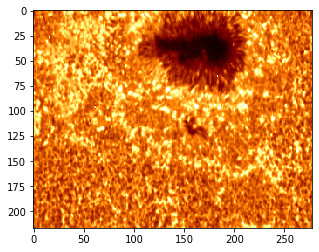

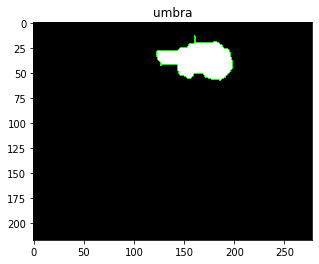

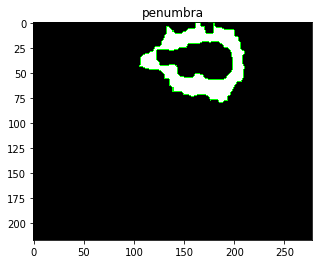

In [5]:
plt.imshow(img_orig)
plt.show()

thresholds = []
# center is a list of colors from the segmentation, sort to find closest to black
# euclidean distance is not ideal for colors, but it's seems okay
center_sort = sorted([(x[0]**2 + x[1]**2 + x[2]**2, i) for i,x in enumerate(center)])

if center_sort[0][0] > 10000:
    print("No sunspots found")
else:
    sunspot = [find_threshold(img, center_sort[0][1]),
               find_threshold(img, center_sort[1][1])]
    
    for i, t in enumerate(sunspot):

        # use RETR_TREE so inside circle of penumbra gets shown as contour
        cnt, _ = cv2.findContours(t, 
                                cv2.RETR_TREE,
                                cv2.CHAIN_APPROX_SIMPLE)
                                
        final = cv2.cvtColor(t, cv2.COLOR_GRAY2RGB)
        cv2.drawContours(final, cnt, -1, (0,255,0), 1)

        plt.imshow(final)
        plt.title(['umbra', 'penumbra'][i])
        plt.show()

    